In [4]:
import numpy as np
import cv2
import os

import torch
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision.utils import save_image, make_grid
import imageio


In [5]:
categories = ['anger','contempt','disgust','fear','happy','sadness','surprise']
data_path = r'./data/CK+48'
paths = []
img_labels = []

for idx,cate in enumerate(categories):
    cate_path = data_path + '/' + cate
    img_list = os.listdir(cate_path)
    for img in img_list:
        img_path = cate_path + '/' + img
        paths.append(img_path)
        img_labels.append(idx)

In [6]:
class Dataset(torch.utils.data.Dataset):
    # Characterizes a dataset for PyTorch
    def __init__(self, paths, img_labels, transform):
        'Initialization'
        self.labels = img_labels
        self.paths = paths
        self.transform = transform

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.paths)

    def __getitem__(self, index):
        # Generates one sample of data
        # Select sample
        path = self.paths[index]

        # Load data and get label
        raw = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        X = transform(raw) 
        y = self.labels[index]

        return X, y

In [7]:
# Parameters
batch_size = 32

In [8]:
transform = transforms.Compose([
        transforms.ToTensor()
    ])
dataset = Dataset(paths, img_labels, transform)

In [9]:
train_size = int(0.8 * len(dataset))
valid_size = len(dataset) - train_size
train_set, valid_set = torch.utils.data.random_split(dataset, [train_size, valid_size])

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=batch_size, shuffle=True, num_workers=0)

In [10]:
kernel_size = 4 # (4, 4) kernel
init_channels = 8 # initial number of filters
image_channels = 1 # CK+ images are grayscale
latent_dim = 16 # latent dimension for sampling

In [11]:
# define a Conv VAE
class ConvVAE(nn.Module):
    def __init__(self):
        super(ConvVAE, self).__init__()
 
        # encoder
        self.enc1 = nn.Conv2d(
            in_channels=image_channels, out_channels=init_channels, kernel_size=kernel_size, 
            stride=2, padding=1
        )
        self.enc2 = nn.Conv2d(
            in_channels=init_channels, out_channels=init_channels*2, kernel_size=kernel_size, 
            stride=2, padding=1
        )
        self.enc3 = nn.Conv2d(
            in_channels=init_channels*2, out_channels=init_channels*4, kernel_size=kernel_size, 
            stride=2, padding=1
        )
        self.enc4 = nn.Conv2d(
            in_channels=init_channels*4, out_channels=64, kernel_size=kernel_size, 
            stride=2, padding=0
        )
        # fully connected layers for learning representations
        self.fc1 = nn.Linear(64, 128)
        self.fc_mu = nn.Linear(128, latent_dim)
        self.fc_log_var = nn.Linear(128, latent_dim)
        self.fc2 = nn.Linear(latent_dim, 64)
        
        # decoder 
        self.dec1 = nn.ConvTranspose2d(
            in_channels=64, out_channels=init_channels*8, kernel_size=kernel_size, 
            stride=2, padding=0
        )
        self.dec2 = nn.ConvTranspose2d(
            in_channels=init_channels*8, out_channels=init_channels*4, kernel_size=kernel_size, 
            stride=2, padding=1
        )
        self.dec3 = nn.ConvTranspose2d(
            in_channels=init_channels*4, out_channels=init_channels*2, kernel_size=kernel_size, 
            stride=2, padding=1
        )
        self.dec4 = nn.ConvTranspose2d(
            in_channels=init_channels*2, out_channels=image_channels, kernel_size=kernel_size, 
            stride=2, padding=1
        )
    def reparameterize(self, mu, log_var):
        """
        :param mu: mean from the encoder's latent space
        :param log_var: log variance from the encoder's latent space
        """
        std = torch.exp(0.5*log_var) # standard deviation
        eps = torch.randn_like(std) # `randn_like` as we need the same size
        sample = mu + (eps * std) # sampling
        return sample
 
    def forward(self, x):
        # encoding
        x = F.relu(self.enc1(x)) 
        #print('1: x = {}'.format(x.shape)) # shape = (N,8,24,24)
        x = F.relu(self.enc2(x))
        #print('2: x = {}'.format(x.shape)) # shape = (N,16,12,12)
        x = F.relu(self.enc3(x))
        #print('3: x = {}'.format(x.shape)) # shape = (N,32,6,6)
        x = F.relu(self.enc4(x))
        #print('4: x = {}'.format(x.shape)) # shape = (N,64,2,2)
        
        batch, _, _, _ = x.shape
        x = F.adaptive_avg_pool2d(x, 1).reshape(batch, -1)
        #print('5: x = {}'.format(x.shape)) # shape = (N,64)
        hidden = self.fc1(x)
        #print('6: x = {}'.format(x.shape)) # shape = (N,64)
        
        # get `mu` and `log_var`
        mu = self.fc_mu(hidden) # shape = (N,16)
        log_var = self.fc_log_var(hidden) # shape = (N.16)
        
        # get the latent vector through reparameterization
        z = self.reparameterize(mu, log_var)
        #print('7: z = {}'.format(z.shape)) # shape = (N,16)
        z = self.fc2(z)
        #print('8: z = {}'.format(z.shape)) # shape = (N,64)
        z = z.view(-1, 64, 1, 1)
        #print('9: z = {}'.format(z.shape)) # shape = (N,64,1,1)
 
        # decoding
        x = F.adaptive_avg_pool2d(z,2)
        #print('9.5: z = {}'.format(x.shape)) # shape = (N,64,2,2)
        x = F.relu(self.dec1(x))
        #print('10: x = {}'.format(x.shape)) # shape = (N,64,6,6)
        x = F.relu(self.dec2(x))
        #print('11: x = {}'.format(x.shape)) # shape = (N,32,12,12)
        x = F.relu(self.dec3(x))
        #print('12: x = {}'.format(x.shape)) # shape = (N,16,24,24)
        reconstruction = torch.sigmoid(self.dec4(x))
        #print('13: reconstruction = {}'.format(reconstruction.shape)) # shape = (N,1,48,48)
        return reconstruction, mu, log_var

In [12]:
def final_loss(bce_loss, mu, logvar):
    """
    This function will add the reconstruction loss (BCELoss) and the 
    KL-Divergence.
    KL-Divergence = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    :param bce_loss: recontruction loss
    :param mu: the mean from the latent vector
    :param logvar: log variance from the latent vector
    """
    BCE = bce_loss 
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

In [30]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# initialize the model
model = ConvVAE().to(device)
# set the learning parameters
lr = 0.001
epochs = 400

optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.BCELoss(reduction='sum')
# a list to save all the reconstructed images in PyTorch grid format
grid_images = []

In [14]:
def train(model, dataloader, dataset, device, optimizer, criterion):
    model.train()
    running_loss = 0.0
    counter = 0
    
    for i, data in enumerate(dataloader):
        counter += 1
        inputs, labels = data[0].to(device), data[1]
        optimizer.zero_grad()
        
        reconstruction, mu, logvar = model(inputs)
        bce_loss = criterion(reconstruction, inputs)
        loss = final_loss(bce_loss, mu, logvar)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    train_loss = running_loss / counter 
    return train_loss

In [15]:
def validate(model, dataloader, dataset, device, criterion):
    model.eval()
    running_loss = 0.0
    counter = 0
    with torch.no_grad():
        for i, data in enumerate(dataloader):
            counter += 1
            inputs, labels = data[0].to(device), data[1]
            
            reconstruction, mu, logvar = model(inputs)
            bce_loss = criterion(reconstruction, inputs)
            loss = final_loss(bce_loss, mu, logvar)
            
            running_loss += loss.item()
        
            # save the last batch input and output of every epoch
            if i == int(len(dataset)/dataloader.batch_size) - 1:
                recon_images = reconstruction
    val_loss = running_loss / counter
    return val_loss, recon_images

In [16]:
def save_reconstructed_images(recon_images, epoch):
    SAVE_DIR = r"C:\Users\trongduong\[QML Study]\VAEoutputs"
    local_path = "output" + str(epoch) + ".jpg"
    path = os.path.join(SAVE_DIR, local_path)
    save_image(recon_images.cpu(), path)

In [32]:
def image_to_vid(images):
    to_pil_image = transforms.ToPILImage()
    imgs = [np.array(to_pil_image(img)) for img in images]
    #print(len(imgs), imgs[0].shape)
    SAVE_DIR = r"C:\Users\trongduong\[QML Study]\VAEoutputs"
    local_path = "generated_images.gif"
    path = os.path.join(SAVE_DIR, local_path)
    imageio.mimsave(path, imgs)

In [18]:
def save_loss_plot(train_loss, valid_loss):
    # loss plots
    plt.figure(figsize=(10, 7))
    plt.plot(train_loss, color='orange', label='train loss')
    plt.plot(valid_loss, color='red', label='validataion loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    SAVE_DIR = r"C:\Users\trongduong\[QML Study]\VAEoutputs"
    local_path = "loss.jpg"
    path = os.path.join(SAVE_DIR, local_path)
    
    plt.savefig(path)
    plt.show()

In [31]:
train_loss = []
valid_loss = []
for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss = train(
        model, train_loader, train_set, device, optimizer, criterion
    )
    valid_epoch_loss, recon_images = validate(
        model, valid_loader, valid_set, device, criterion
    )
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    # save the reconstructed images from the validation loop
    save_reconstructed_images(recon_images, epoch+1)
    # convert the reconstructed images to PyTorch image grid format
    image_grid = make_grid(recon_images.detach().cpu())
    grid_images.append(image_grid)
    print(f"Train Loss: {train_epoch_loss:.4f}")
    print(f"Val Loss: {valid_epoch_loss:.4f}")

SAVE_DIR = r"C:\Users\trongduong\[QML Study]\saved_models"
local_path = "VAE.pth"
path = os.path.join(SAVE_DIR, local_path)
torch.save(model.cpu().state_dict(), path)

Epoch 1 of 400
Train Loss: 49403.4516
Val Loss: 43035.0192
Epoch 2 of 400
Train Loss: 45946.9148
Val Loss: 39877.7086
Epoch 3 of 400
Train Loss: 43238.5928
Val Loss: 38406.2048
Epoch 4 of 400
Train Loss: 42124.5255
Val Loss: 37714.5201
Epoch 5 of 400
Train Loss: 41736.5023
Val Loss: 37641.8448
Epoch 6 of 400
Train Loss: 41467.6645
Val Loss: 37394.9492
Epoch 7 of 400
Train Loss: 41284.1114
Val Loss: 37266.3685
Epoch 8 of 400
Train Loss: 41213.5941
Val Loss: 37341.6576
Epoch 9 of 400
Train Loss: 41196.7098
Val Loss: 37214.8152
Epoch 10 of 400
Train Loss: 41030.5764
Val Loss: 37002.8908
Epoch 11 of 400
Train Loss: 40824.3405
Val Loss: 36791.1675
Epoch 12 of 400
Train Loss: 40596.2101
Val Loss: 36747.7361
Epoch 13 of 400
Train Loss: 40441.6181
Val Loss: 36512.9326
Epoch 14 of 400
Train Loss: 40281.4402
Val Loss: 36417.4099
Epoch 15 of 400
Train Loss: 40110.0515
Val Loss: 36378.2609
Epoch 16 of 400
Train Loss: 40004.3235
Val Loss: 36181.5945
Epoch 17 of 400
Train Loss: 39916.2180
Val Loss: 

Train Loss: 38209.6139
Val Loss: 34690.8713
Epoch 138 of 400
Train Loss: 38182.4288
Val Loss: 34670.2702
Epoch 139 of 400
Train Loss: 38161.8348
Val Loss: 34611.5070
Epoch 140 of 400
Train Loss: 38153.2119
Val Loss: 34652.6387
Epoch 141 of 400
Train Loss: 38162.0084
Val Loss: 34681.0231
Epoch 142 of 400
Train Loss: 38136.9895
Val Loss: 34614.3428
Epoch 143 of 400
Train Loss: 38129.7736
Val Loss: 34627.1338
Epoch 144 of 400
Train Loss: 38127.0196
Val Loss: 34642.0388
Epoch 145 of 400
Train Loss: 38129.3283
Val Loss: 34607.2219
Epoch 146 of 400
Train Loss: 38111.3891
Val Loss: 34602.5160
Epoch 147 of 400
Train Loss: 38111.4948
Val Loss: 34666.3322
Epoch 148 of 400
Train Loss: 38135.8384
Val Loss: 34627.8645
Epoch 149 of 400
Train Loss: 38126.4484
Val Loss: 34672.0613
Epoch 150 of 400
Train Loss: 38212.2952
Val Loss: 34743.8201
Epoch 151 of 400
Train Loss: 38143.7029
Val Loss: 34592.8135
Epoch 152 of 400
Train Loss: 38090.6275
Val Loss: 34589.3014
Epoch 153 of 400
Train Loss: 38095.9833
V

Train Loss: 37668.1523
Val Loss: 34267.9360
Epoch 273 of 400
Train Loss: 37670.9458
Val Loss: 34248.0497
Epoch 274 of 400
Train Loss: 37700.4326
Val Loss: 34292.3772
Epoch 275 of 400
Train Loss: 37694.7177
Val Loss: 34305.6353
Epoch 276 of 400
Train Loss: 37696.4196
Val Loss: 34248.5877
Epoch 277 of 400
Train Loss: 37644.9848
Val Loss: 34252.3278
Epoch 278 of 400
Train Loss: 37655.3203
Val Loss: 34270.8743
Epoch 279 of 400
Train Loss: 37676.7425
Val Loss: 34273.2317
Epoch 280 of 400
Train Loss: 37646.1010
Val Loss: 34307.2130
Epoch 281 of 400
Train Loss: 37675.3850
Val Loss: 34239.9688
Epoch 282 of 400
Train Loss: 37643.4493
Val Loss: 34217.8989
Epoch 283 of 400
Train Loss: 37633.8985
Val Loss: 34296.0529
Epoch 284 of 400
Train Loss: 37638.9750
Val Loss: 34223.6305
Epoch 285 of 400
Train Loss: 37641.5736
Val Loss: 34250.0888
Epoch 286 of 400
Train Loss: 37644.5320
Val Loss: 34232.2985
Epoch 287 of 400
Train Loss: 37610.9265
Val Loss: 34204.6076
Epoch 288 of 400
Train Loss: 37631.0116
V

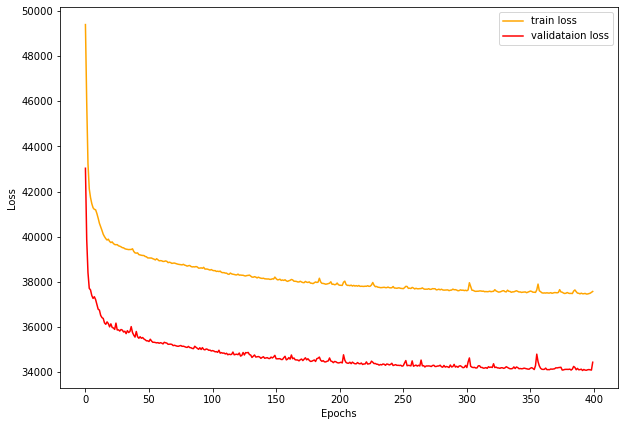

TRAINING COMPLETE


In [33]:
#save the reconstructions as a .gif file
image_to_vid(grid_images)
#save the loss plots to disk
save_loss_plot(train_loss, valid_loss)
print('TRAINING COMPLETE')